# Model Training

### Import Libraries

In [1]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score



### Import CSV

In [2]:
df = pd.read_csv(r'data\WA_Fn-UseC_-Telco-Customer-Churn.csv')

### Feature Extraction

In [3]:
df['Churn'] = df['Churn'].astype('string').str.strip()
df = df[df['Churn'].isin(['Yes', 'No'])].copy()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
numerical_features = [f for f in df.columns if df[f].dtype != 'object' and df[f].nunique() > 2]
binary_features = [col for col in df.columns if df[col].nunique() == 2]
categorical_features = list(set([f for f in df.columns if df[f].dtype == 'object'] + binary_features) - {'Churn', 'customerID'})
target = df['Churn']
print("Numerical Features: ",numerical_features)
print("Categorical Features: ", categorical_features)
print("Target: ", [target.name])

Numerical Features:  ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Features:  ['InternetService', 'DeviceProtection', 'TechSupport', 'PaperlessBilling', 'Contract', 'OnlineBackup', 'gender', 'StreamingMovies', 'PaymentMethod', 'SeniorCitizen', 'PhoneService', 'MultipleLines', 'Dependents', 'Partner', 'StreamingTV', 'OnlineSecurity']
Target:  ['Churn']


### X and Y Variables

In [4]:
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

In [5]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: string

### Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (4930, 19), (4930,)
Test shape: (2113, 19), (2113,)


In [8]:
print(X_train.columns.tolist())


['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


### Transformers

Using pipelines, we can pass in the transformations in steps of imputing and scaling the numerical features and imputing and one-hot encoding the categorcal features to prepare our data for training. Defining this after the train-test split to avoid leakage. 


In [9]:
numerical_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numerical_pipeline = Pipeline(steps = [('imputer', numerical_imputer), ('scaler', scaler)])

categorical_imputer = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder()

categorical_pipeline = Pipeline(steps = [('imputer', categorical_imputer),('encoder', encoder)])


preprocessor = ColumnTransformer(transformers = [('num_trans', numerical_pipeline, numerical_features), ('cat_trans', categorical_pipeline, categorical_features)])    

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

### Training Phase

Function to return some important statistics: 

In [10]:
def evaluate_clf(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else float("nan")
    return acc, pre, rec, f1, auc

Computing weights to balance classes in xgboost and catboost models: 

In [11]:
ytr_enc = y_train.map({"No": 0, "Yes": 1})
mask = ytr_enc.notna()

n = (ytr_enc == 0).sum()
p = (ytr_enc == 1).sum()

xgb_scale = n/p

total = n + p

w0 = total/(2*n)
w1 = total/(2*p)


Models chosen to run: 

In [12]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced'),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBClassifier": XGBClassifier(scale_pos_weight=xgb_scale),
    "CatBoostClassifier": CatBoostClassifier(verbose=False, class_weights=[w0, w1]),
    "AdaBoost Classifier": AdaBoostClassifier()
}


Running the models: 

In [13]:
models_list, f1_scores_list = [], []

for name, model in models.items(): 
    model.fit(X_train_prep, ytr_enc)
    
    y_pred_train = model.predict(X_train_prep)
    y_pred_test = model.predict(X_test_prep)
    y_proba_test = None
    
    if hasattr(model, "predict_proba"):
        y_proba_test = model.predict_proba(X_test_prep)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test_prep).reshape(-1, 1)
        y_proba_test = MinMaxScaler().fit_transform(scores).reshape(-1)

    tr_acc, tr_pre, tr_rec, tr_f1, _ = evaluate_clf(ytr_enc, y_pred_train)
    te_acc, te_pre, te_rec, te_f1, te_auc = evaluate_clf(
        y_test.map({"No":0,"Yes":1}).astype(int), y_pred_test, y_proba_test
    )

    print(name)
    models_list.append(name)
    print('Model performance (Train)')
    print(f"- Accuracy: {tr_acc:.4f}  Precision: {tr_pre:.4f}  Recall: {tr_rec:.4f}  F1: {tr_f1:.4f}")
    print('----------------------------------')
    print('Model performance (Test)')
    print(f"- Accuracy: {te_acc:.4f}  Precision: {te_pre:.4f}  Recall: {te_rec:.4f}  F1: {te_f1:.4f}  AUC: {te_auc:.4f}")
    f1_scores_list.append(te_f1)
    print('='*35, '\n')

Logistic Regression
Model performance (Train)
- Accuracy: 0.7471  Precision: 0.5150  Recall: 0.8028  F1: 0.6274
----------------------------------
Model performance (Test)
- Accuracy: 0.7440  Precision: 0.5114  Recall: 0.7968  F1: 0.6230  AUC: 0.8443

K-Neighbors Classifier
Model performance (Train)
- Accuracy: 0.8383  Precision: 0.7135  Recall: 0.6529  F1: 0.6818
----------------------------------
Model performance (Test)
- Accuracy: 0.7615  Precision: 0.5514  Recall: 0.5455  F1: 0.5484  AUC: 0.7864

Decision Tree
Model performance (Train)
- Accuracy: 0.9978  Precision: 0.9924  Recall: 0.9992  F1: 0.9958
----------------------------------
Model performance (Test)
- Accuracy: 0.7118  Precision: 0.4582  Recall: 0.4688  F1: 0.4634  AUC: 0.6343

Random Forest
Model performance (Train)
- Accuracy: 0.9980  Precision: 0.9954  Recall: 0.9969  F1: 0.9962
----------------------------------
Model performance (Test)
- Accuracy: 0.7832  Precision: 0.6229  Recall: 0.4652  F1: 0.5327  AUC: 0.8147

X

In [14]:
pd.DataFrame(list(zip(models_list, f1_scores_list)), columns=['Model', 'F1-Score']).sort_values(by=['F1-Score'], ascending=False)

,Model,F1-Score
0,Logistic Regression,0.622997
5,CatBoostClassifier,0.620384
4,XGBClassifier,0.592233
6,AdaBoost Classifier,0.576505
1,K-Neighbors Classifier,0.548387
3,Random Forest,0.532653
2,Decision Tree,0.463436


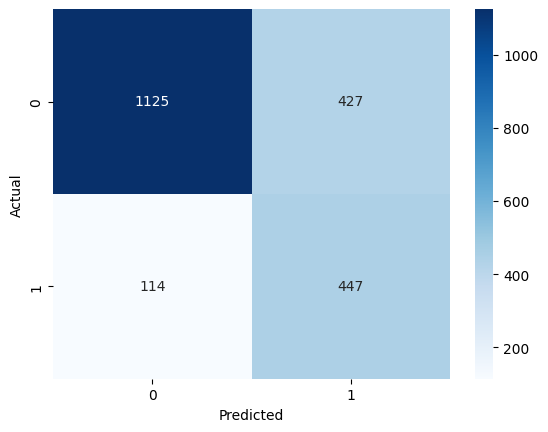

In [15]:
y_test= y_test.map({'Yes':1, 'No':0}).astype(int)
best = LogisticRegression(max_iter=500, class_weight='balanced')
model = best.fit(X_train_prep, ytr_enc)
y_pred = model.predict(X_test_prep)
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- Winner: Logistic Regression (class_weight='balanced') generalizes best — Test: F1 0.623, Recall 0.797, Precision 0.511, AUC 0.844, Accuracy 0.744. 

- We catch ~80% of churners; about 49% of alerts are false positives. 